# Importing libraries and data


## Libraries


In [1]:
import itk
import vtk

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go


## Data Loading


In [2]:
scan1_path = "data/case6_gre1.nrrd"
scan2_path = "data/case6_gre2.nrrd"

scan1 = itk.imread(scan1_path, itk.F)
scan2 = itk.imread(scan2_path, itk.F)

vtk_scan1 = itk.vtk_image_from_image(scan1)
vtk_scan2 = itk.vtk_image_from_image(scan2)


## Data Visualization


In [3]:
def show_images(images, index, titles):

    gridX = 1
    gridY = len(images)

    fig = plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = fig.add_subplot(gridX, gridY, i + 1)
        ax.imshow(images[i][index, :, :])
        ax.set_title(titles[i])
        ax.axis("off")

    plt.show()


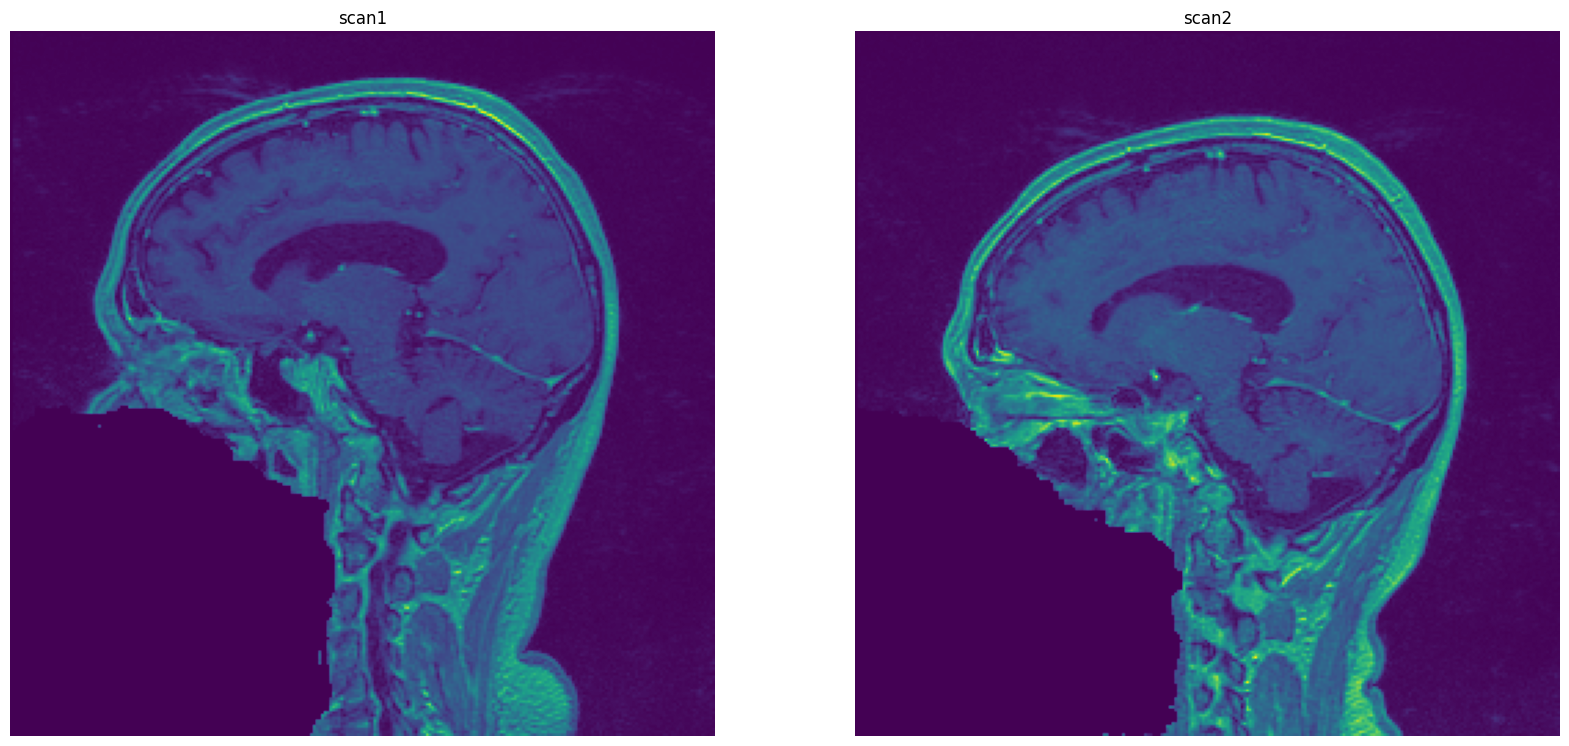

In [4]:
show_images([scan1, scan2], 100, ["scan1", "scan2"])


# Image Repositioning


## Registration

In [5]:
def register(fixed_image, moving_image):

    # create registration object
    registration_method = itk.ImageRegistrationMethodv4[itk.Image[itk.F, 3], itk.Image[itk.F, 3]].New(
    )

    # set registration method
    registration_method.SetFixedImage(fixed_image)
    registration_method.SetMovingImage(moving_image)

    # set initial transform
    initial_transform = itk.TranslationTransform[itk.D, 3].New()
    initial_transform.SetIdentity()
    registration_method.SetInitialTransform(initial_transform)

    # set metric
    metric = itk.MeanSquaresImageToImageMetricv4[itk.Image[itk.F, 3], itk.Image[itk.F, 3]].New(
    )
    registration_method.SetMetric(metric)

    # set optimizer
    optimizer = itk.RegularStepGradientDescentOptimizerv4[itk.D].New()
    optimizer.SetLearningRate(4)
    optimizer.SetMinimumStepLength(0.001)
    optimizer.SetRelaxationFactor(0.5)
    optimizer.SetNumberOfIterations(200)
    registration_method.SetOptimizer(optimizer)

    # set interpolator
    # interpolator = itk.LinearInterpolateImageFunction[itk.Image[itk.F, 3], itk.D].New()
    # registration_method.SetInterpolator(interpolator)

    # perform registration
    registration_method.Update()

    # get transform
    final_transform = registration_method.GetTransform()
    return final_transform


In [6]:
final_transform = register(scan1, scan2)
print(final_transform)


TranslationTransform (0x2b213ecb0)
  RTTI typeinfo:   itk::TranslationTransform<double, 3u>
  Reference Count: 1
  Modified Time: 2414
  Debug: Off
  Object Name: 
  Observers: 
    none
  Offset: [-0.833913, -3.54112, -59.4551]



## Apply Transformation

In [7]:
def apply_transform(transform, image):

    resample_filter = itk.ResampleImageFilter.New(image)
    resample_filter.SetTransform(transform)
    resample_filter.SetOutputParametersFromImage(image)
    resample_filter.SetDefaultPixelValue(0)
    resample_filter.Update()
    return resample_filter.GetOutput()


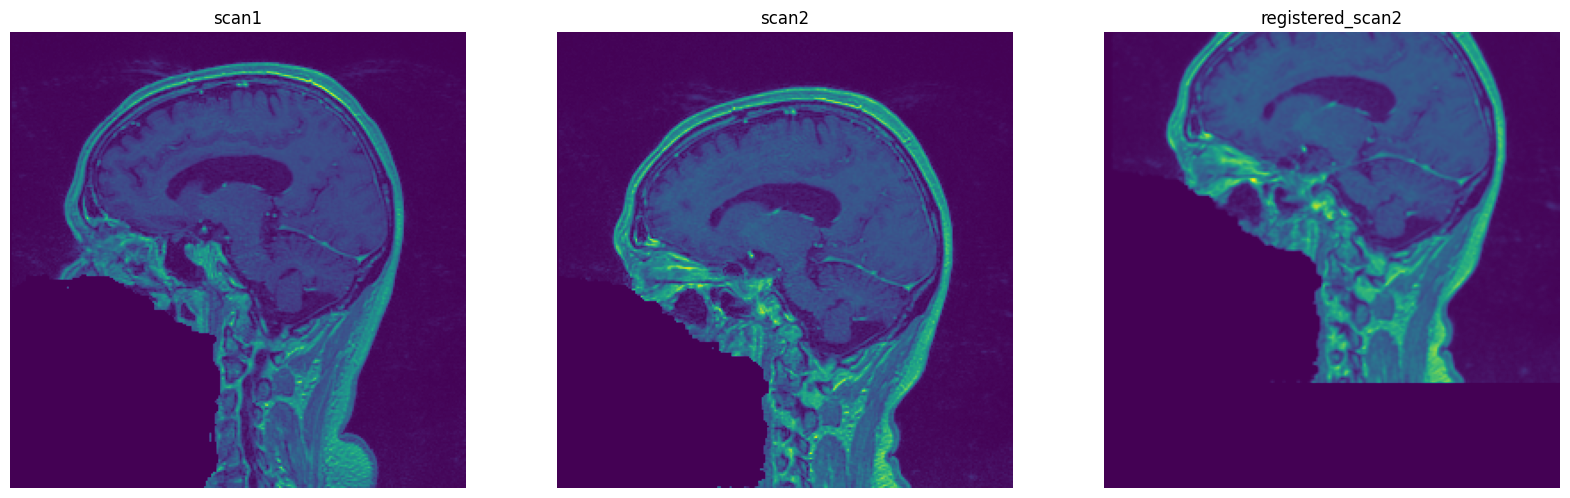

In [8]:
registered_scan2 = apply_transform(final_transform, scan2)

show_images([scan1, scan2, registered_scan2], 100,
            ["scan1", "scan2", "registered_scan2"])
